# Fine-Tuning ProPicker

In this notebook, we fine-tune ProPicker for picking ribosomes in the EMPIAR-10988 dataset. 

We use a crop of size `128x128x128` voxels extracted from the center of the `TS_029` tomogram and corresponding ground truth-annotations for fine-tuning. The crop contains 65 ribosomes which is less than 3% of the total number of ribosomes in the full `TS_029` tomogram.
For early stopping, we use `128x128x128` a center crop from `TS_030` and corresponding ground-truth annotations (66 ribosomes).


In [1]:
import torch

from matplotlib import pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter

from clustering_and_picking import get_cluster_centroids_df
from evaluation import evaluate_picks, get_best_case_cluster_based_picking_performance
from paths import EMPIAR10988_BASE_DIR, TOMOTWIN_MODEL_FILE, PROPICKER_MODEL_FILE
from data.preparation_functions.prepare_empiar10988 import read_empiar10988_coords, empiar10988_ts_to_slice_of_interest
from data.utils import draw_balls
from inference.tomotwin import get_tomotwin_prompt_embeds_dict

from model import ProPicker
from utils.mrctools import *

# disable warnings for chained assignments in pandas
pd.options.mode.chained_assignment = None  # default='warn'


## Step 1: Prompt Extraction and Embedding

For fine-tuning ProPicker, we first need to extract a prompt, which is used to condition the model and which we keep fixed during fine-tuning. We use the same prompt as for the clustering-based picking approach.

In [2]:
ts_id = "TS_030"

tomo_file = f"{EMPIAR10988_BASE_DIR}/tomograms/{ts_id}.rec"
ribo_coord_file = f"{EMPIAR10988_BASE_DIR}/particle_lists/{ts_id}_cyto_ribosomes.csv"

# tomograms contain large emtpy regions, so we only consider the interesting part
slice_of_interest = empiar10988_ts_to_slice_of_interest[ts_id]
tomo = -1 * load_mrc_data(tomo_file).float()
tomo = tomo[slice_of_interest].clone()


coords = read_empiar10988_coords(ribo_coord_file)
coords.Z -= slice_of_interest.start

# extract all ribosomes as subtomos of shape (37, 37, 37); this shape is the one needed for the TomoTwin prompt encoder
all_ribo_subtomos = []
for coord in coords[["X", "Y", "Z"]].values.astype(int):
    x, y, z = coord
    subtomo = tomo[
        z-18:z+19,
        y-18:y+19,
        x-18:x+19
    ]
    # some ribosomes are at the edge of the tomogram, so we skip them
    if not subtomo.shape == (37, 37, 37):
        continue
    all_ribo_subtomos.append(subtomo)
    
# you can choose any of the ribo subtomos as prompt
prompt = all_ribo_subtomos[300]
prompt_subtomos_dict = {"cyto_ribosome": prompt}

/home/simon/ProPicker/utils/mrctools.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538456841/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  data = torch.from_numpy(mrc.data)


We embed the prompt using tomotwin and save the embedding to disk, as we need it for fine-tuning.

In [4]:
prompt_embeds_dict = get_tomotwin_prompt_embeds_dict(
    prompt_subtomos_dict=prompt_subtomos_dict, 
    tomotwin_model_file=TOMOTWIN_MODEL_FILE, 
    device="cuda:2", 
    batch_size=1, 
    out_file="./fixed_prompts_empiar10988.json"
)


/home/simon/ProPicker/inference/tomotwin.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weightspth, map_location=device)


Model config:
{'identifier': 'SiameseNet', 'network_config': {'output_channels': 32, 'dropout': 0.2, 'repeat_layers': 0, 'norm_name': 'GroupNorm', 'norm_kwargs': {'num_groups': 64, 'num_channels': 1024}, 'gem_pooling_p': 0}, 'train_config': {'loss': 'TripletLoss', 'tl_margin': 0.539, 'miner': True, 'miner_margin': 0.734, 'learning_rate': 5.945e-05, 'optimizer': 'Adam', 'weight_decay': 0, 'batchsize': 35, 'patience': 50, 'aug_train_shift_distance': 2}, 'distance': 'COSINE'}
Successfully loaded model weights


Passing subtomos through TomoTwin: 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


## Step 2: Fine-Tuning

Code for fine-tuning is in `empiar10988_fine_tuning.py`. We recommend to have a look at the code as there are some hyperparameters that can be adjusted, then run the script in the `deepetpicker` environment:

```bash
conda activate deepetpicker
python empiar10988_fine_tuning.py
```

With the current settings, the script fine-tunes ProPicker on a crop of size `256x256x256` voxels (around ) extracted from the center of `TS_029`. A center crop of the same size taken from `TS_030` is used as validation set.

Running the fine-tuning script will create a directory `fine_tuning_empiar10988/crop_delta=64`, which contains all outputs produced in hte process. You can monitor the fine-uning using TensorBoard.

## Step 3: Inference with the Fine-Tuned Model

Inference with the fine-tuned model is handled in `empiar10988_inference.py`. 
```bash
python empiar10988_inference.py
```

**Important:** Before you can run the script, you have to adjust the path to the model checkpoint in the script itself.

Within `fine_tuning_empiar10988/crop_delta=64/runs`, you can now find the `full_segmentation_output` directory which contains the full 3D segmentation mask of the test tomogram produced with the fine-tuned model. Let's have a look at it:

/tmp/ipykernel_4044449/3220126412.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pred_locmap = torch.load("./fine_tuning_empiar10988/crop_delta=64/runs/train/train_ProP

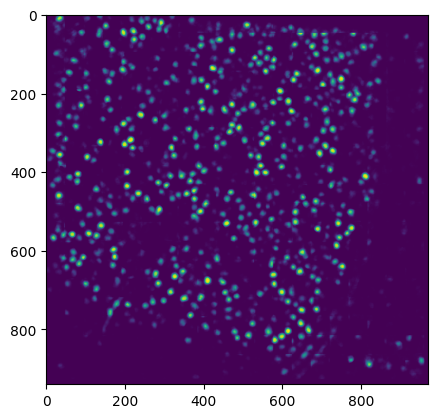

In [19]:
pred_locmap = torch.load("./fine_tuning_empiar10988/crop_delta=64/runs/train/train_ProPicker_BlockSize72_CELoss_MaxEpoch100_bs8_lr0.001_IP1_bg1_coord1_Softmax0_bn__TNNone/version_0/full_segmentation_output/TS_030.pt")
plt.imshow(pred_locmap[100])

In [ ]:
# binarization
binarization_thresh = 0.5  # after fine-tuning the model is usually much more confident so you have to increase the binarization threshold to avoid overlapping particle clusters
binary_locmap = pred_locmap > binarization_thresh

# clustering
cluster_centroids = get_cluster_centroids_df(binary_locmap)

# size-based filtering
ball_volume = 4/3 * torch.pi * (24/2)**3  
min_cluster_size = 0.1 * ball_volume  
max_cluster_size = 1.2 * ball_volume 

cluster_centroids_filt = cluster_centroids[
    (min_cluster_size <= cluster_centroids["size"]) & (cluster_centroids["size"] <= max_cluster_size)
]

print(f"Number of clusters: {len(cluster_centroids_filt)}")
print(cluster_centroids_filt.head(5))

Number of clusters: 2199
       X      Y    Z  size
0  723.0   41.0  4.0  1120
2  221.0   77.0  6.0  1218
3  170.0  324.0  6.0  1592
4  546.0  398.0  6.0  1984
5  634.0   39.0  7.0   889


In [16]:
bbox_size = 37
coords["height"] = coords["width"] = coords["depth"] = bbox_size
cluster_centroids_filt["height"] = cluster_centroids_filt["width"] = cluster_centroids_filt["depth"] = bbox_size
cluster_centroids_filt["class"] = "cyto_ribosome"

evaluate_picks(
    pred_positions=cluster_centroids_filt,
    gt_positions=coords,
    iou_thresh=0.6,
)

{'cyto_ribosome': {'F1': 0.7032309533306741,
  'Recall': 0.6334890406036651,
  'Precision': 0.7902285970416854,
  'TruePositiveRate': 0.6334890406036651,
  'TP': 1763,
  'FP': 468,
  'FN': 1020}}

## Conclusion

Fine-tuning ProPicker significantly improves the performance of the model on the EMPIAR-10988 dataset. The fine-tuned model has higher precison and recall but most improvements are in recall.